In [ ]:
import numpy as np
import bz2
from collections import Counter
import re
import nltk
import torch
import math
import random
from torch import nn
from torch import optim
from torch import Tensor
from torch import LongTensor
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import logging
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:
logging.basicConfig(format='%(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')
logging.getLogger().setLevel(logging.INFO)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = '/content/drive/My Drive/RA - Pathak/Attn/data/'

## Load the dataset

In [ ]:
nltk.download('punkt')

ts_file = bz2.BZ2File(data_dir + "test.ft.txt.bz2")
tr_file = bz2.BZ2File(data_dir + "train.ft.txt.bz2")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
tr_file = tr_file.readlines()
ts_file = ts_file.readlines()

In [ ]:
num_train = 200000  # We're training on the first 800,000 reviews in the dataset
num_test = 20000  # Using 200,000 reviews from test set
#trn_file = random.sample(tr_file, num_train)
#tst_file = random.sample(tr_file, num_test)

In [ ]:
train_file = [x.decode('utf-8') for x in tr_file[:num_train]]
test_file = [x.decode('utf-8') for x in ts_file[:num_test]]
#train_file = [x.decode('utf-8') for x in trn_file]
#test_file = [x.decode('utf-8') for x in tst_file]

## Preprocessing

In [ ]:
# Extracting labels from sentences
train_labels = [[0,1] if x.split(' ')[0] == '__label__1' else [1,0] for x in train_file]
train_sentences = [x.split(' ', 1)[1][:-1].lower() for x in train_file]

test_labels = [[0,1] if x.split(' ')[0] == '__label__1' else [1,0] for x in test_file]
test_sentences = [x.split(' ', 1)[1][:-1].lower() for x in test_file]

# Some simple cleaning of data
for i in range(len(train_sentences)):
    train_sentences[i] = re.sub('\d','0',train_sentences[i])

for i in range(len(test_sentences)):
    test_sentences[i] = re.sub('\d','0',test_sentences[i])

# Modify URLs to <url>
for i in range(len(train_sentences)):
    if 'www.' in train_sentences[i] or 'http:' in train_sentences[i] or 'https:' in train_sentences[i] or '.com' in train_sentences[i]:
        train_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", train_sentences[i])
        
for i in range(len(test_sentences)):
    if 'www.' in test_sentences[i] or 'http:' in test_sentences[i] or 'https:' in test_sentences[i] or '.com' in test_sentences[i]:
        test_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", test_sentences[i])

In [ ]:
train_sentences[1]

"the best soundtrack ever to anything.: i'm reading a lot of reviews saying that this is the best 'game soundtrack' and i figured that i'd write a review to disagree a bit. this in my opinino is yasunori mitsuda's ultimate masterpiece. the music is timeless and i'm been listening to it for years now and its beauty simply refuses to fade.the price tag on this is pretty staggering i must say, but if you are going to buy any cd for this much money, this is the only one that i feel would be worth every penny."

In [ ]:
a = ["i'm a dota"]
punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
        
for i, test_str in enumerate(a):
    for ele in test_str:  
        if ele in punc:  
            if ele == "'":
                a[i] = a[i].replace(ele, "")  
            else:
                a[i] = a[i].replace(ele, " ")  

a

['im a dota']

In [ ]:
punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''

for i, test_str in enumerate(test_sentences):
    for ele in test_str:  
        if ele in punc:  
            if ele == "'":
                test_sentences[i] = test_sentences[i].replace(ele, "")  
            else:
                test_sentences[i] = test_sentences[i].replace(ele, " ")  

for i, train_str in enumerate(train_sentences):
    for ele in train_str:  
        if ele in punc:  
            if ele == "'":
                train_sentences[i] = train_sentences[i].replace(ele, "")  
            else:
                train_sentences[i] = train_sentences[i].replace(ele, " ")  

In [ ]:
train_sentences[1]

'the best soundtrack ever to anything   im reading a lot of reviews saying that this is the best game soundtrack and i figured that id write a review to disagree a bit  this in my opinino is yasunori mitsudas ultimate masterpiece  the music is timeless and im been listening to it for years now and its beauty simply refuses to fade the price tag on this is pretty staggering i must say  but if you are going to buy any cd for this much money  this is the only one that i feel would be worth every penny '

In [ ]:
words = Counter()  # Dictionary that will map a word to the number of times it appeared in all the training sentences
for i, sentence in enumerate(train_sentences):
    # The sentences will be stored as a list of words/tokens
    train_sentences[i] = []
    for word in nltk.word_tokenize(sentence):  # Tokenizing the words
        words.update([word.lower()])  # Converting all the words to lowercase
        train_sentences[i].append(word)
    if i%20000 == 0:
        print(str((i*100)/num_train) + "% done")
print("100% done")

0.0% done
10.0% done
20.0% done
30.0% done
40.0% done
50.0% done
60.0% done
70.0% done
80.0% done
90.0% done
100% done


In [ ]:
# Removing the words that only appear once
words = {k:v for k,v in words.items() if v>1}
# Sorting the words according to the number of appearances, with the most common word being first
words = sorted(words, key=words.get, reverse=True)
# Adding padding and unknown to our vocabulary so that they will be assigned an inde0x
words = ['_PAD','_UNK'] + words
# Dictionaries to store the word to index mappings and vice versa
word2idx = {o:i for i,o in enumerate(words)}
idx2word = {i:o for i,o in enumerate(words)}

In [ ]:
for i, sentence in enumerate(train_sentences):
    # Looking up the mapping dictionary and assigning the index to the respective words
    train_sentences[i] = [word2idx[word] if word in word2idx else 0 for word in sentence]

for i, sentence in enumerate(test_sentences):
    # For test sentences, we have to tokenize the sentences as well
    test_sentences[i] = [word2idx[word.lower()] if word.lower() in word2idx else 0 for word in nltk.word_tokenize(sentence)]

In [ ]:
# Defining a function that either shortens sentences or pads sentences with 0 to a fixed length
def pad_input(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

seq_len = 200  # The length that the sentences will be padded/shortened to

train_sentences = pad_input(train_sentences, seq_len)
test_sentences = pad_input(test_sentences, seq_len)

# Converting our labels into numpy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [ ]:
train_sentences[145]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [ ]:
len(test_sentences)

20000

In [ ]:
split_frac = 0.5 # 30% validation, 70% test
split_id = int(split_frac * len(test_sentences))
val_sentences, test_sentences = test_sentences[:split_id], test_sentences[split_id:]
val_labels, test_labels = test_labels[:split_id], test_labels[split_id:]

In [ ]:
for i in test_sentences[5]:
    s = idx2word[i]
    if s != '_PAD':
        print(s, end=" ")

the fulfillment of desire i didnt care for the method of presentation monotone i felt like i had to work to hard to get what could have been with a easier approach deepak moves through some material way to fast and seemed to come to a almost deadening halt going through why the hand bones connected to the wrist bone which is connected to the arm bone etc to each his own but i found this one to have way to much info that i still am wondering why it was in there i gave my cds away i recommend ask and it is given part 0 at least by esther jerry hicks for the law of attraction 

In [ ]:

print(len(test_sentences))
print(len(val_sentences))

10000
10000


## Data Loaders

In [ ]:
train_data = TensorDataset(torch.from_numpy(train_sentences), torch.from_numpy(train_labels))
val_data = TensorDataset(torch.from_numpy(val_sentences), torch.from_numpy(val_labels))
test_data = TensorDataset(torch.from_numpy(test_sentences), torch.from_numpy(test_labels))

batch_size = 200
#batch_size = 10
#batch_size = 100


"""
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)
"""

train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [ ]:
len(test_loader)

50

## GPU check

In [ ]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
device

device(type='cuda')

## LSTM Class

In [ ]:
class Model(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers=1, drop_prob=0.2):
        super(Model, self).__init__()
        self.hidden_layer = hidden_dim
        self.embedding_dim = embedding_dim
        self.num_layers = n_layers
        self.bi_num_layers = 2
        self.output_size = output_size
        self.drop_prob = drop_prob

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=self.embedding_dim,
        )
        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.hidden_layer,
            num_layers=self.num_layers,
            bidirectional=True,
        )
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(p=self.drop_prob)
        self.alpha = nn.Linear(2*self.hidden_layer, 1)
        #self.r = nn.Linear(2*self.hidden_layer, 1)
        self.softmax = nn.Softmax(dim=1)
        self.fc = nn.Linear(2*self.hidden_layer, output_size)
        #self.sigmoid = nn.Sigmoid()
        self.softmax_fc = nn.Softmax(dim=1)

    def forward(self, x, prev_state):
        batch_size = x.size(0)
        embed = self.embedding(x)

        output, state = self.lstm(embed, prev_state)
        #print('lstm output',output.shape)
        # [10, 200, 256] 

        """
        ### Just LSTM
        o = self.tanh(output)
        o = self.fc(o)

        o = o[:, -1, :]
        o = self.softmax_fc(o)
        a_out = []
        return o, state, a_out
        ###
        """

        # attention layer
        output = self.tanh(output)
        output = self.dropout(output)
        a_out = self.alpha(output)
        a_out = self.softmax(a_out)
        #print('a_out',a_out.shape)
        #[10, 200 , 1]

        r_t =  torch.transpose(output, -1 , 1)
        #print('r_t',r_t.shape)
        # [10, 256, 200]
        
        r_out = torch.bmm(r_t, a_out)
        #print('r_out',r_out.shape)
        # [10, 256 , 1]

        out = r_out.squeeze()
        # [10, 256]

        out = self.tanh(out)
        out = self.dropout(out)
        out = self.fc(out)
        out = self.softmax_fc(out)
        #print('final_fc_out',out.shape)
        # [10,2]
        return out, state, a_out

    def init_state(self, sequence_length):
        return (torch.zeros(self.bi_num_layers, sequence_length, self.hidden_layer),
                torch.zeros(self.bi_num_layers, sequence_length, self.hidden_layer))

In [ ]:
class Model(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers=1, drop_prob=0.2):
        super(Model, self).__init__()
        self.hidden_layer = hidden_dim
        self.embedding_dim = embedding_dim
        self.num_layers = n_layers
        self.bi_num_layers = 2
        self.output_size = output_size
        self.drop_prob = drop_prob

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=self.embedding_dim,
        )
        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.hidden_layer,
            num_layers=self.num_layers,
            batch_first=True,
            bidirectional=True,
        )
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(p=self.drop_prob)
        self.alpha = nn.Linear(2*self.hidden_layer, 1)
        #self.r = nn.Linear(2*self.hidden_layer, 1)
        self.softmax = nn.Softmax(dim=1)
        self.fc = nn.Linear(2*self.hidden_layer, output_size)
        #self.sigmoid = nn.Sigmoid()
        self.softmax_fc = nn.Softmax(dim=1)

    def forward(self, x, prev_state):
        batch_size = x.size(0)
        embed = self.embedding(x)

        output, state = self.lstm(embed, prev_state)
        #print('lstm output',output.shape)
        # [10, 200, 256] 

        """
        ### Just LSTM
        o = self.tanh(output)
        o = self.fc(o)

        o = o[:, -1, :]
        o = self.softmax_fc(o)
        a_out = []
        return o, state, a_out
        ###
        """

        # attention layer
        output = self.tanh(output)
        output = self.dropout(output)
        a_out = self.alpha(output)
        a_out = self.softmax(a_out)
        #print('a_out',a_out.shape)
        #[10, 200 , 1]

        r_t =  torch.transpose(output, -1 , 1)
        #print('r_t',r_t.shape)
        # [10, 256, 200]
        
        r_out = torch.bmm(r_t, a_out)
        #print('r_out',r_out.shape)
        # [10, 256 , 1]

        out = r_out.squeeze()
        # [10, 256]

        out = self.tanh(out)
        out = self.dropout(out)
        out = self.fc(out)
        out = self.softmax_fc(out)
        #print('final_fc_out',out.shape)
        # [10,2]
        return out, state, a_out

    def init_state(self, batch_size):
        return (torch.zeros(self.bi_num_layers, batch_size, self.hidden_layer),
                torch.zeros(self.bi_num_layers, batch_size, self.hidden_layer))

## Train the model

In [ ]:
vocab_size = len(word2idx) + 1
batch_size = 200
output_size = 2
embedding_dim = 100
#embedding_dim = 100
hidden_dim = 256
n_layers = 1
drop_prob=0.3
model = Model(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob)
model = model.to(device)
model
# [ bs = 200, embed = 100, hidden=64, drop=0.3, lr=0.001, epoch=10]

Model(
  (embedding): Embedding(80540, 100)
  (lstm): LSTM(100, 256, batch_first=True, bidirectional=True)
  (tanh): Tanh()
  (dropout): Dropout(p=0.3, inplace=False)
  (alpha): Linear(in_features=512, out_features=1, bias=True)
  (softmax): Softmax(dim=1)
  (fc): Linear(in_features=512, out_features=2, bias=True)
  (softmax_fc): Softmax(dim=1)
)

In [ ]:
columns = ['layers', 'shape', 'parameters']
df = pd.DataFrame(columns=columns)
n = []
s = []
p = []
r = []
for name, param in model.named_parameters():
    # if param.requires_grad:
        # n = str(name)
        # s = str(param.shape)
        # p = str(param.numel())
        n.append(str(name))
        s.append(str(param.shape))
        p.append(str(param.numel()))
        r.append(str(param.requires_grad))
        # df=df.append(n, s , p)

df['layers'] = n
df['shape'] = s
df['parameters'] = p
df['requires_grad'] = r
df

,layers,shape,parameters,requires_grad
0,embedding.weight,"torch.Size([80540, 100])",8054000,True
1,lstm.weight_ih_l0,"torch.Size([1024, 100])",102400,True
2,lstm.weight_hh_l0,"torch.Size([1024, 256])",262144,True
3,lstm.bias_ih_l0,torch.Size([1024]),1024,True
4,lstm.bias_hh_l0,torch.Size([1024]),1024,True
5,lstm.weight_ih_l0_reverse,"torch.Size([1024, 100])",102400,True
6,lstm.weight_hh_l0_reverse,"torch.Size([1024, 256])",262144,True
7,lstm.bias_ih_l0_reverse,torch.Size([1024]),1024,True
8,lstm.bias_hh_l0_reverse,torch.Size([1024]),1024,True
9,alpha.weight,"torch.Size([1, 512])",512,True


In [ ]:
model.train()
epochs = 20
sequence_length = seq_len
counter = 0
clip = 5
print_every = 100
valid_loss_min = np.Inf
all_weights = []
all_train_loss = []
all_val_loss = []
criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=5e-4)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.Adam(model.parameters(), lr=0.01)
#optimizer = optim.RMSprop(model.parameters(), lr=0.01)
val_dl = val_loader


for epoch in range(epochs):
    #state_h, state_c = model.init_state(sequence_length)
    model.train()
    h = model.init_state(batch_size)

    train_losses = []
    validation_losses = []

    for inputs, labels in train_loader:
        counter += 1
        h = tuple([e.data for e in h])
        h = [x.to(device) for x in h]
        inputs, labels = inputs.to(device), labels.to(device)

        model.zero_grad()
        output, h, _ = model(inputs, h)
        loss = criterion(output.squeeze(), labels.float())
        train_losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        #nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        
    model.eval()
    val_h = model.init_state(batch_size)
    for inp, lab in val_loader:
        val_h = tuple([each.data for each in val_h])
        val_h = [x.to(device) for x in val_h]
        inp, lab = inp.to(device), lab.to(device)

        out, _ , _ = model(inp, val_h)
        val_loss = criterion(out.squeeze(), lab.float())
        validation_losses.append(val_loss.item())

        
    all_train_loss.append(np.mean(train_losses))
    all_val_loss.append(np.mean(validation_losses))
    
    logging.info("Epoch {}: {:.6f} loss, {:.6f} val loss".format(epoch+1, np.mean(train_losses), np.mean(validation_losses)))

17-Feb-21 02:00:58 - Epoch 1: 0.491979 loss, 0.417597 val loss
17-Feb-21 02:01:38 - Epoch 2: 0.348655 loss, 0.362622 val loss
17-Feb-21 02:02:19 - Epoch 3: 0.303606 loss, 0.323763 val loss
17-Feb-21 02:02:59 - Epoch 4: 0.268398 loss, 0.276417 val loss
17-Feb-21 02:03:39 - Epoch 5: 0.238600 loss, 0.256266 val loss
17-Feb-21 02:04:20 - Epoch 6: 0.221053 loss, 0.242800 val loss
17-Feb-21 02:05:00 - Epoch 7: 0.210466 loss, 0.231575 val loss
17-Feb-21 02:05:40 - Epoch 8: 0.204045 loss, 0.233010 val loss
17-Feb-21 02:06:20 - Epoch 9: 0.200153 loss, 0.223546 val loss
17-Feb-21 02:07:00 - Epoch 10: 0.196515 loss, 0.227783 val loss
17-Feb-21 02:07:41 - Epoch 11: 0.193464 loss, 0.227849 val loss
17-Feb-21 02:08:21 - Epoch 12: 0.190982 loss, 0.221852 val loss
17-Feb-21 02:09:02 - Epoch 13: 0.188193 loss, 0.219895 val loss
17-Feb-21 02:09:42 - Epoch 14: 0.186441 loss, 0.215358 val loss
17-Feb-21 02:10:22 - Epoch 15: 0.183815 loss, 0.221619 val loss
17-Feb-21 02:11:03 - Epoch 16: 0.182309 loss, 0.2

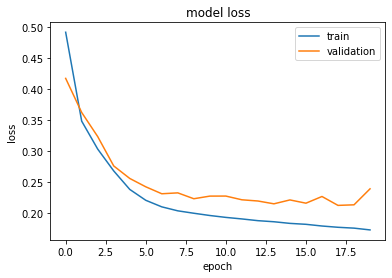

In [ ]:
plt.plot(all_train_loss)
plt.plot(all_val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
model_dir = '/content/drive/My Drive/RA - Pathak/Attn/data/'
# torch.save(model, model_dir + "thesis-imdb-bi-attn-200k-best.pickle")
model = torch.load(model_dir + "thesis-imdb-bi-attn-200k-best.pickle")

In [ ]:
!pip uninstall torch

Uninstalling torch-1.2.0:
  Would remove:
    /usr/local/bin/convert-caffe2-to-onnx
    /usr/local/bin/convert-onnx-to-caffe2
    /usr/local/lib/python3.7/dist-packages/caffe2/*
    /usr/local/lib/python3.7/dist-packages/torch-1.2.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/torch/*
Proceed (y/n)? y
  Successfully uninstalled torch-1.2.0


In [ ]:
!pip install torch==1.7.1

     |████████████████████████████████| 776.8MB 23kB/s 
ERROR: torchvision 0.9.0+cu101 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.


In [ ]:
test_losses = []
num_correct = 0
a_weights = []
pred_label = []
true_label = []
prediction = []
dict = {}
test_sen = []
criterion = nn.BCELoss()

h = model.init_state(batch_size)
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        h = tuple([each.data for each in h])
        h = [x.to(device) for x in h]
        inputs, labels = inputs.to(device), labels.to(device)
        output, h, a_out = model(inputs, h)

        for out in output:
            o = out.cpu().numpy()
            prediction.append(o)
            # o = out.round().cpu().numpy()
            # if o[0] == 0 :   #this mean _label1_ bad
            #     pred_label.append(0)
            # else:            #this mean _label2_ good
            #     pred_label.append(1)


        for label in labels:
            l = label.cpu().numpy()
            if l[0] == 0 :
                true_label.append(1)
            else:
                true_label.append(0)

        for inp in inputs:
            test_sen.append(inp)
            
        for each_a_out in a_out:
            a_weights.append(each_a_out)
            
        test_loss = criterion(output.squeeze(), labels.float())
        test_losses.append(test_loss.item())

print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/len(test_loader.dataset)
#print("Test accuracy: {:.3f}%".format(test_acc*100))

Test loss: 0.208


In [ ]:
prediction1 = np.argmax(prediction, axis=1)  ## Prediction for bad reviews in terms of 0 and 1 for all test data
prediction_for_1=[] ## Prediction for bad reviews only
for each_prediction in prediction:
    prediction_for_1.append(each_prediction[1])

c = confusion_matrix(true_label,prediction1)

[Text(0, 0.5, 'good'), Text(0, 1.5, 'bad')]

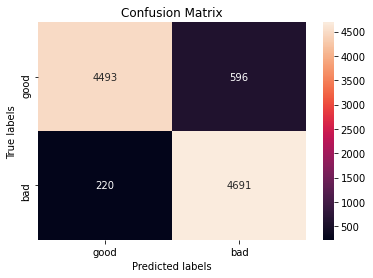

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(c, annot=True, fmt='g')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['good', 'bad']) 
ax.yaxis.set_ticklabels(['good', 'bad'])

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score
from inspect import signature

truelabel = true_label
predictedlabel = np.array(prediction1)

precision, recall, _ = precision_recall_curve(truelabel,np.array(prediction_for_1))
au = auc(recall, precision)
print("Area under graph "+str(au))
print("-------------------------------------------------")
rec_score = recall_score(truelabel,predictedlabel,pos_label=1,average='binary')
precise_score = precision_score(truelabel,predictedlabel,pos_label=1,average='binary')
f1 = f1_score(truelabel,predictedlabel,pos_label=1, average='binary')
print("Precision for bad reviews "+str(precise_score))
print("Recall for bad reviews "+str(rec_score))
print("F1-score for bad reviews  " + str(f1))
print("-------------------------------------------------")
rec_score = recall_score(truelabel,predictedlabel,pos_label=0,average='binary')
precise_score = precision_score(truelabel,predictedlabel,pos_label=0,average='binary')
f1 = f1_score(truelabel,predictedlabel,pos_label=0, average='binary')
print("Precision for good reviews "+str(precise_score))
print("Recall for good reviews "+str(rec_score))
print("F1-score for good reviews  " + str(f1))

Area under graph 0.9762805671679567
-------------------------------------------------
Precision for bad reviews 0.8872706638925667
Recall for bad reviews 0.9552026063938098
F1-score for bad reviews  0.9199843106491469
-------------------------------------------------
Precision for good reviews 0.9533206025885848
Recall for good reviews 0.8828846531735115
F1-score for good reviews  0.9167516833299326


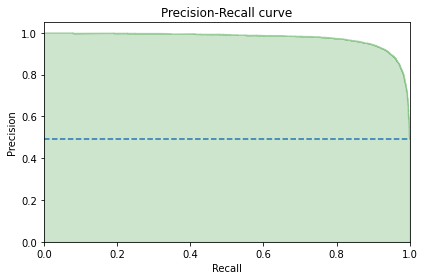

In [ ]:
positive_cases = sum(truelabel)/len(truelabel)
plt.plot([0, 1], [positive_cases, positive_cases], linestyle='--')

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
                if 'step' in signature(plt.fill_between).parameters
                else {})
plt.step(recall, precision, color='g', alpha=0.2,
            where='post')
plt.fill_between(recall, precision, alpha=0.2, color='g', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.tight_layout()

In [ ]:
sen_index = 2698
#[40,1000, 57, 299, 300, 302, 308, 483, 388, 345]
ts = test_sen[sen_index].cpu().detach().numpy()
for i in ts:
    s = idx2word[i]
    if s != '_PAD':
        print(s, end=" "),

dict = {}
for i in range(0,200):
    s = idx2word[ts[i]]
    if s != '_PAD' and s!= '00':
        dict[s] = a_weights[sen_index][i].cpu().detach().numpy()

cols = ['values']
df = pd.DataFrame.from_dict(dict, orient='index', columns = cols)
df = df.sort_values(by='values', ascending=False)
df.head(20)

not too enamored of 00s rock n roll and france this little film is a bit schizophrenic and a little too staged for comfort we are in post war france but we are also in a little american bubble as gis bring american culture to a place that doesnt need it theres a little teen love story mixed in here but overall i wasnt entertained 

,values
wasnt,0.251545
not,0.129865
roll,0.045280
n,0.038778
overall,0.031391
rock,0.029861
00s,0.025312
bit,0.019551
enamored,0.016915
are,0.013414


In [ ]:
sen_index = 7472
#[40,1000, 57, 299, 300, 302, 308, 483, 388, 345]
ts = test_sen[sen_index].cpu().detach().numpy()
for i in ts:
    s = idx2word[i]
    if s != '_PAD':
        print(s, end=" "),

dict = {}
for i in range(0,200):
    s = idx2word[ts[i]]
    if s != '_PAD' and s!= '00':
        dict[s] = a_weights[sen_index][i].cpu().detach().numpy()

cols = ['values']
df = pd.DataFrame.from_dict(dict, orient='index', columns = cols)
df = df.sort_values(by='values', ascending=False)
df.head(20)

just right without breaking the bank if you are thinking about getting an intro surround system this is a great beginner intermediate component to start with dont waste your money on inferior turn key systems for 000 to 000 but rather spend a little more 000 to 0k and build a great system wich you will enjoy for years i never knew my speakers were so capable of producing such quality sound the onkyo is worth the price and is user friendly only the instructions dont exactly match the actual set up steps this however is not a problem since setup and operation is intuative and easy via the display on the receiver 

,values
worth,0.054529
onkyo,0.043934
beginner,0.043310
just,0.041319
without,0.036008
right,0.035129
waste,0.032669
breaking,0.023489
intermediate,0.019136
such,0.018704


In [ ]:
sen_index = 388
#[40,1000, 57, 299, 300, 302, 308, 483, 388, 345]
ts = test_sen[sen_index].cpu().detach().numpy()
for i in ts:
    s = idx2word[i]
    if s != '_PAD':
        print(s, end=" "),

dict = {}
for i in range(0,200):
    s = idx2word[ts[i]]
    if s != '_PAD' and s!= '00':
        dict[s] = a_weights[sen_index][i].cpu().detach().numpy()

cols = ['values']
df = pd.DataFrame.from_dict(dict, orient='index', columns = cols)
df = df.sort_values(by='values', ascending=False)
df.head(20)

fantastic i love this book absolutely a keeper the length of time it for the book to get to me was very short i am very satisfied 

,values
love,0.271138
fantastic,0.229067
am,0.085098
absolutely,0.070243
very,0.052919
a,0.049384
short,0.027503
i,0.019308
keeper,0.013610
this,0.013360


In [ ]:
dict = {}
for i in range(0,200):
    s = idx2word[ts[i]]
    dict[s] = a_weights[sen_index][i].cpu().detach().numpy()

cols = ['values']
df = pd.DataFrame.from_dict(dict, orient='index', columns = cols)
df = df.sort_values(by='values', ascending=False)
df.head(20)

,values
product,0.196885
buy,0.156681
great,0.108753
capsules,0.070333
smooth,0.050611
these,0.046544
like,0.022623
really,0.022113
separate,0.020371
i,0.017249
